In [1]:
import requests
import pandas as pd

payment_methods = ["Zinli", "WallyTech", "SkrillMoneybookers", "DukascopyBank", "NETELLER", "Facebank", "Prex"]

# Initialize empty DataFrames for asks and bids
all_asks = pd.DataFrame()
all_bids = pd.DataFrame()

url = 'https://2txjwiew8a.execute-api.us-east-1.amazonaws.com/pre/latest/order-book'
params_base = {
    'fiat': 'USD',
    'asset': 'USDT',
    'trans_amount': 500
}



In [2]:
for method in payment_methods:
    # Update parameters with the current payment method
    params = params_base.copy()
    params['payment_methods'] = method

    # Sending the GET request
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # Create DataFrames for 'asks' and 'bids' and add payment method column
        df_asks = pd.DataFrame(data['aks'])
        df_asks['payment_method'] = method

        df_bids = pd.DataFrame(data['bids'])
        df_bids['payment_method'] = method

        # Concatenate to the main DataFrames
        all_asks = pd.concat([all_asks, df_asks], ignore_index=True)
        all_bids = pd.concat([all_bids, df_bids], ignore_index=True)
    else:
        print(f"Request failed for payment method {method} with status code:", response.status_code)


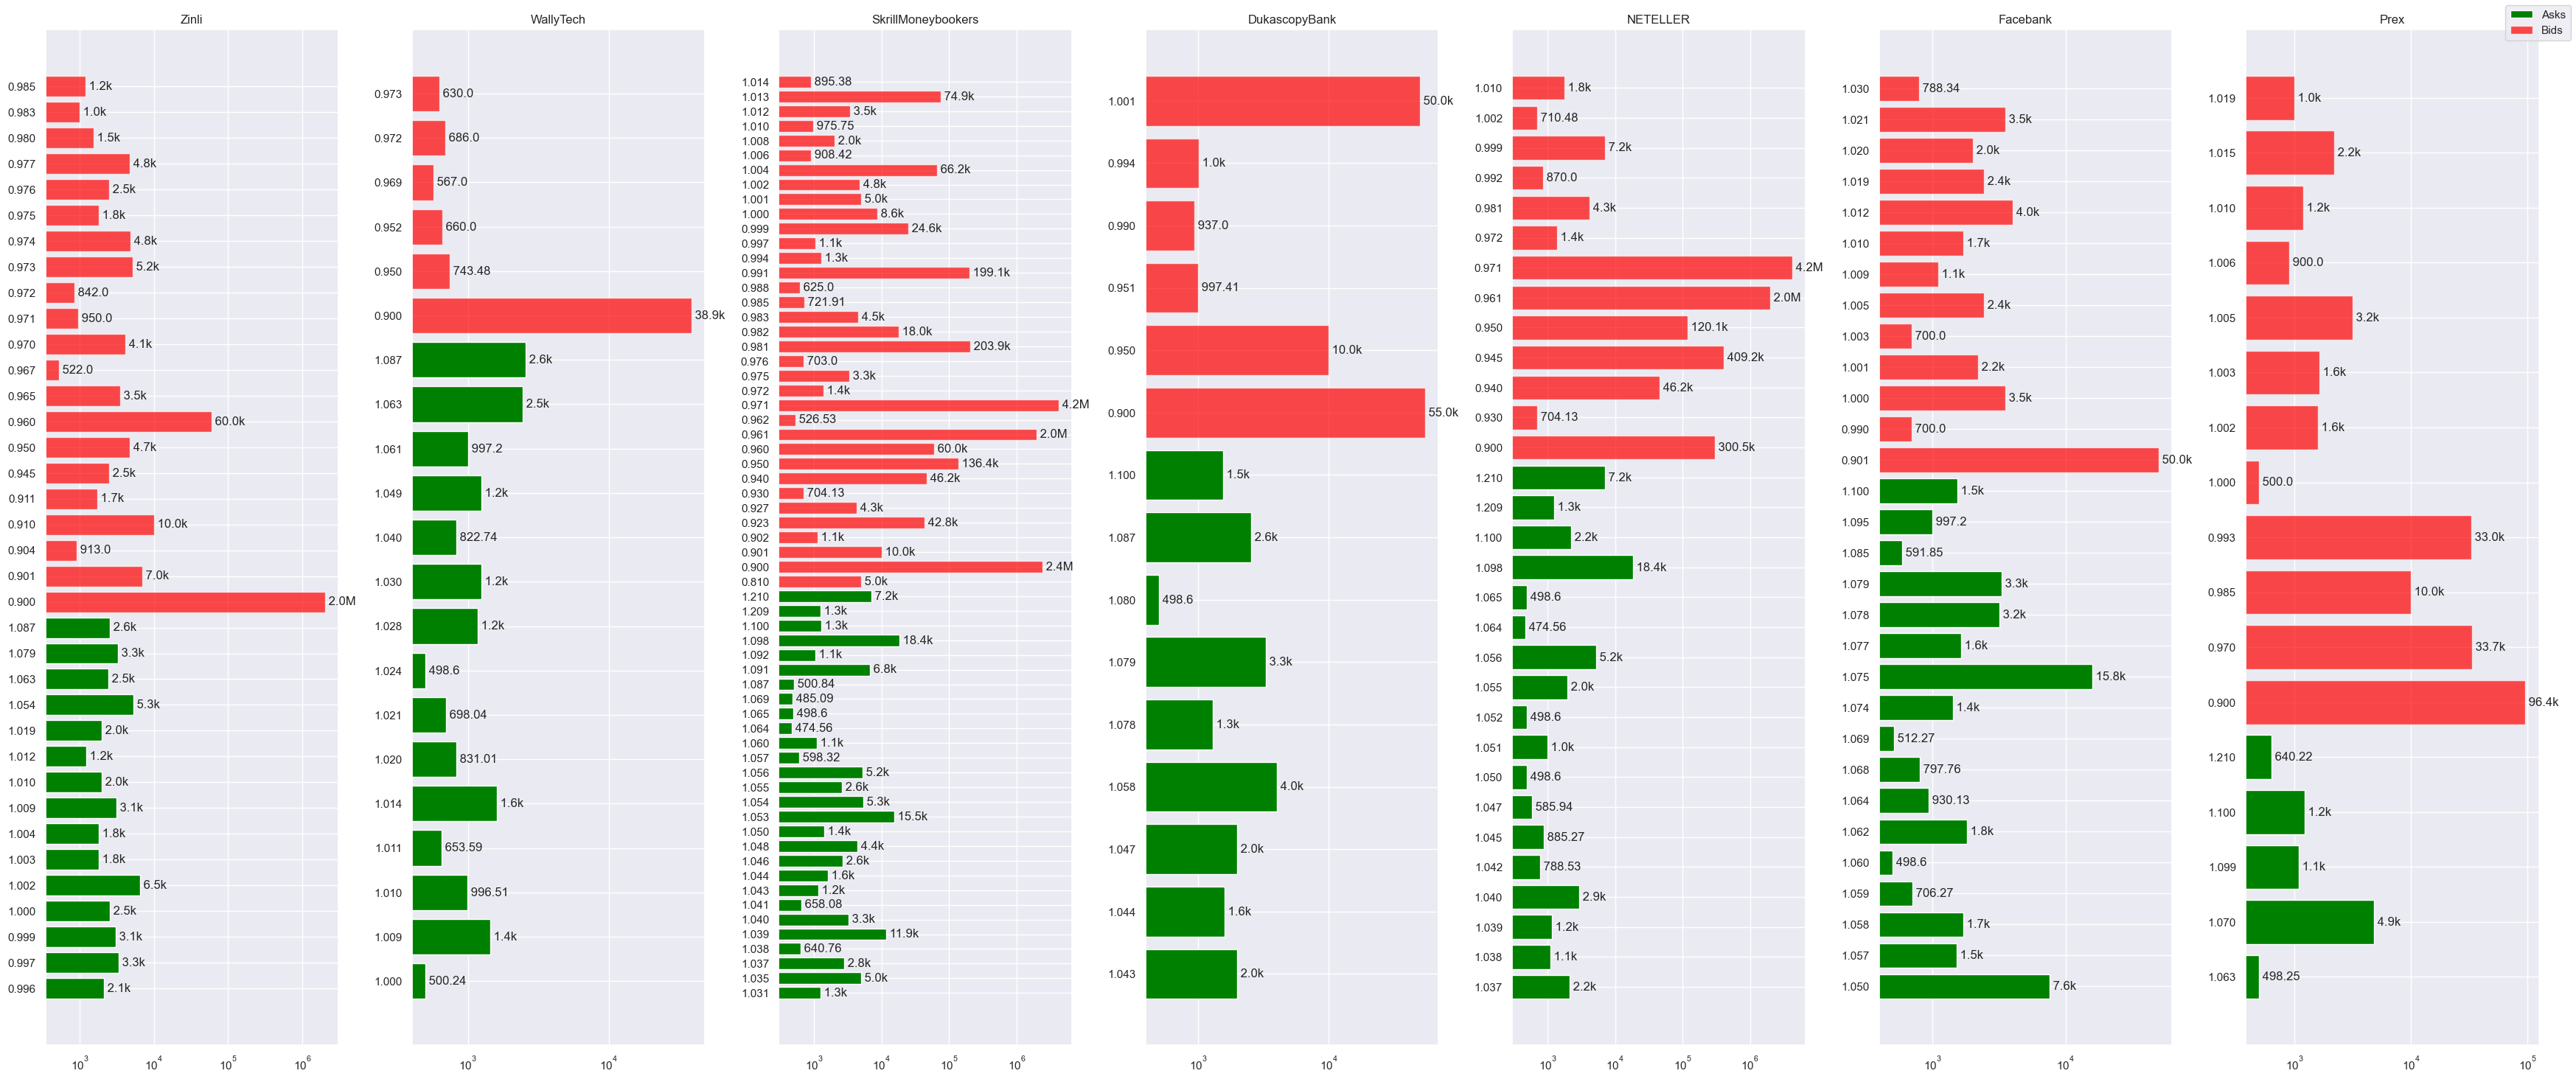

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def abbreviate_number(num):
    """
    Abbreviate a number using 'k', 'M', 'B', etc.
    """
    if num < 1000:
        return str(num)
    for unit in ['k', 'M', 'B', 'T']:
        num /= 1000
        if num < 1000:
            return f"{num:.1f}{unit}"

# Apply the default Seaborn theme
sns.set_theme()

# Count the number of payment methods
num_methods = len(payment_methods)

# Calculate the maximum number of distinct prices across all payment methods
max_prices = max(
    all_asks.groupby('payment_method')['price'].nunique().max(), 
    all_bids.groupby('payment_method')['price'].nunique().max()
)


height_per_subplot = max(6, 0.3 * max_prices) * 1.4  # 40% increase

# Create a figure and a set of subplots with adjusted height
fig, axes = plt.subplots(1, num_methods, figsize=(5 * num_methods, height_per_subplot))

if num_methods == 1:
    axes = [axes]

# Loop through each payment method and create a subplot
for ax, method in zip(axes, payment_methods):
    asks_for_method = all_asks[all_asks['payment_method'] == method].sort_values(by='price', ascending=True)
    bids_for_method = all_bids[all_bids['payment_method'] == method].sort_values(by='price', ascending=True)

    # Plotting asks and bids
    asks_bars = ax.barh(asks_for_method['price'], asks_for_method['available'], color='green', label='Asks')
    bids_bars = ax.barh(bids_for_method['price'], bids_for_method['available'], color='red', label='Bids', alpha=0.7)

    # Add data labels
    for bar in asks_bars + bids_bars:
        width = bar.get_width()
        label = abbreviate_number(width)
        ax.text(width, bar.get_y() + bar.get_height() / 2, f' {label}', va='center')

    # Make the 'available' axis logarithmic
    ax.set_xscale('log')

    # Setting the title
    ax.set_title(f'{method}')

# Add a legend
fig.legend(['Asks', 'Bids'], loc='upper right')

plt.tight_layout()
plt.show()
